In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, Add
from tensorflow.keras import Model
from tensorflow.keras.regularizers import L2
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [4]:
env = 'local'

if (env == 'colab'):
    from google.colab import drive
    drive.mount('/content/drive')

    #cp -r /content/drive/MyDrive/ColabNotebooks/FaceUpscale/data.zip /content
    #7z x data.zip

    #unzip data.zip /content/data

    #unzip /content/drive/MyDrive/ColabNotebooks/FaceUpscale/data.zip /content/data
    #7z x /content/drive/MyDrive/ColabNotebooks/FaceUpscale/data.zip /content/data -o: /content/data

    train_folder = '/content/train'
    test_folder = '/content/test'
    cache_folder = '/content/cache'
    train_batch_size = 32

if (env == 'local'):
    train_folder = '../data/train'
    test_folder = '../data/test'
    cache_folder = '../data/cache'
    train_batch_size = 64

file_cache_enabled = False

x_img_size = 32

y_img_size = 128
y_img_channels = 3


if (file_cache_enabled and cache_folder is not None and not os.path.exists(cache_folder)):
    os.makedirs(cache_folder)

In [5]:
file_cache_write = 0
file_cache_read = 0
file_source_read = 0

train_files_list = []
test_files_list = []

def reset_cache_counters():
    global file_cache_write 
    global file_cache_read 
    global file_source_read
    file_cache_write = 0
    file_cache_read = 0
    file_source_read = 0

def image_file_iterator(root):
    for subdir, dirs, files in os.walk(root):        
        for file in files:
            if (file.endswith('.png')):
                yield os.path.join(subdir, file)

        for dir in dirs:
            for file in image_file_iterator(dir):
                yield os.path.join(subdir, file)

def train_files_shuffled_iterator():
    global train_files_list
    if (len(train_files_list) == 0):
        train_files_list = list(image_file_iterator(train_folder))

    np.random.shuffle(train_files_list)

    for f in train_files_list:
        yield f

def test_files_iterator():
    global test_files_list
    if (len(test_files_list) == 0):
        test_files_list = list(image_file_iterator(test_folder))

    for f in test_files_list:
        yield f

def scale_and_normalize(img, size):
    if (img.shape[0] != size or img.shape[1] != size):
        img = cv2.resize(img, (size, size))
    return img / 255

def make_cache_file_name(id, img_size, prefix):
    return prefix + str(hash(id + str(img_size))) + '.bin'

def load_cached_array(id, img_size, prefix):
    file = os.path.join(cache_folder, make_cache_file_name(id, img_size, prefix))

    if (os.path.exists(file)):
        global file_cache_read
        file_cache_read += 1
        return np.fromfile(file)
    else:
        return None

def save_array_to_cache(arr, id, img_size, prefix):
    file = os.path.join(cache_folder, make_cache_file_name(id, img_size, prefix))

    if (not os.path.exists(file)):
        global file_cache_write
        file_cache_write += 1
        arr.tofile(file)

def load_cached_xy_train(id):
    x_cached = load_cached_array(id, x_img_size, '_x')

    if (x_cached is None):
        return (None, None)
    
    y_cached = load_cached_array(id, y_img_size, '_y')

    if (y_cached is None):
        return (None, None)
    
    return (x_cached.reshape(x_img_size, x_img_size), y_cached.reshape(y_img_size, y_img_size, 3))

def save_xy_train_to_cache(id, x_img, y_img):
    save_array_to_cache(x_img, id, x_img_size, "_x")
    save_array_to_cache(y_img, id, y_img_size, "_y")

def data_iterator(file_iterator, batch_size):
    global file_cache_enabled
    files_pending = True
    while(files_pending):
        x_batch = []
        y_batch = []

        for ii in range(batch_size):
            fpath = next(file_iterator, None) 

            if (fpath is not None):

                x_img = None
                y_img = None

                if (file_cache_enabled):
                  # try to load cached data
                  x_img, y_img = load_cached_xy_train(fpath)

                if (x_img is None or y_img is None):
                    # Load source image
                    global file_source_read
                    file_source_read += 1
                    src_img = cv2.imread(fpath)
                    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
                    # Make X
                    x_img = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
                    x_img = scale_and_normalize(x_img, x_img_size)
                    # Make Y
                    y_img = scale_and_normalize(src_img, y_img_size)

                    if (file_cache_enabled):
                      # Save to cache
                      save_xy_train_to_cache(fpath, x_img, y_img)

                x_batch.append(x_img)
                y_batch.append(y_img)

            else:
                files_pending = False
                break
        
        if len(x_batch) > 0:
            yield np.array(x_batch), np.array(y_batch)

In [6]:
# Let's see the number of data
train_set_len = sum(1 for _ in image_file_iterator(train_folder))
test_set_len = sum(1 for _ in image_file_iterator(test_folder))

print(train_set_len)
print(test_set_len)

# Also do a smoke test for datagen 
# for 1000 test images we expecting 1000 batches (when batch_size = 1)
if (sum(1 for _ in data_iterator(test_files_iterator(), batch_size=1)) != test_set_len):
    print('datagen failure!')

# for 1000 test images we expecting 500 batches (when batch_size = 2)
if (sum(1 for _ in data_iterator(test_files_iterator(), 2)) != test_set_len / 2):
    print('datagen failure!')

print('Source reads:', file_source_read)
print('Cache reads:', file_cache_read)
print('Cache writes:', file_cache_write)

# Let's visualize cached image to ensure it cached and read OK
reset_cache_counters()
cached_x_batch, cached_y_batch = next(data_iterator(test_files_iterator(), batch_size=1))
# ensure images were load from cache
if (file_cache_read == 2):
    plt.subplot(121), plt.imshow(cached_x_batch[0], cmap='gray')  
    plt.subplot(122), plt.imshow(cached_y_batch[0]) 
    print('cached x shape:', cached_x_batch[0].shape)
    print('cached y shape:', cached_y_batch[0].shape)
else:
    print('cache failure!')



65284
1000
Source reads: 2000
Cache reads: 0
Cache writes: 0
cache failure!


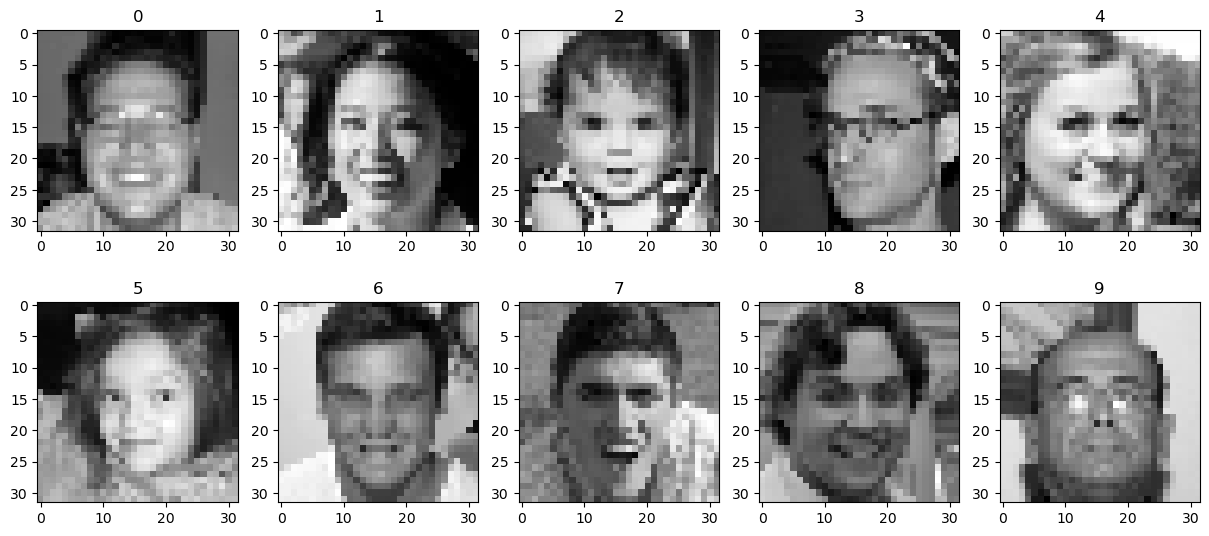

In [7]:
# test datagen
batch = next(data_iterator(train_files_shuffled_iterator(), 10))

x_train_batch = batch[0]
y_train_batch = batch[1]

# Show x_train
for ii in range(x_train_batch.shape[0]):
    plt.subplot(3,5,ii+1), plt.imshow(x_train_batch[ii], cmap = 'gray'), plt.title(ii)

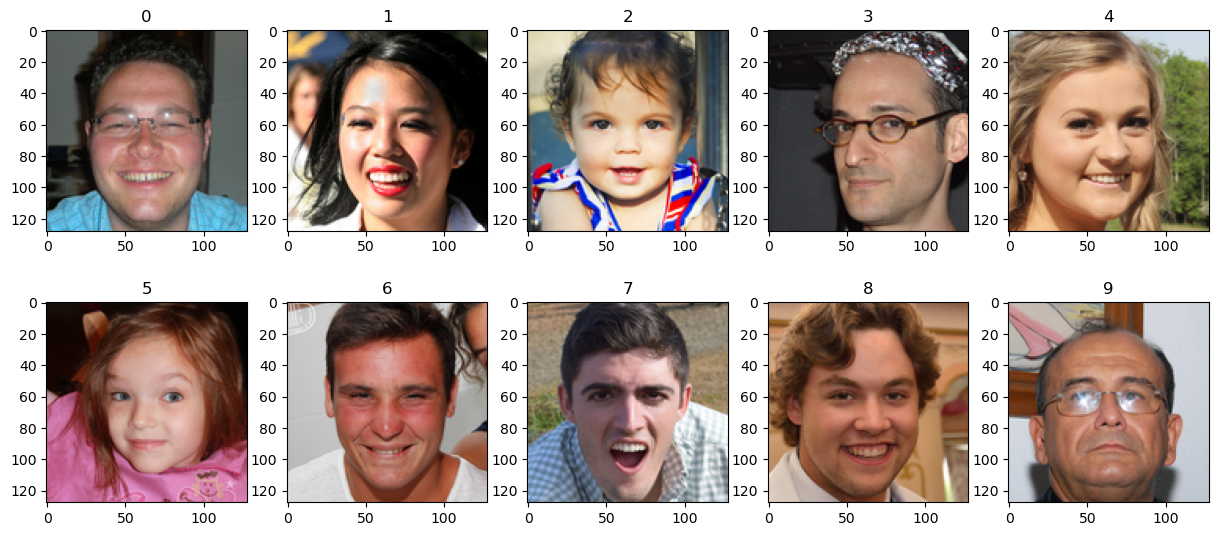

In [8]:
# Show y_train
for ii in range(y_train_batch.shape[0]):
    plt.subplot(3,5,ii+1), plt.imshow(y_train_batch[ii]), plt.title(ii)

In [15]:
# Data Augmentation

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def make_augmentation(input_batch):
    x_list = []
    y_list = []
    input_batch_len = input_batch[0].shape[0]

    sharp_k = 1.2
    sharp_kernel = np.array([[-sharp_k,-sharp_k,-sharp_k], [-sharp_k,9*sharp_k,-sharp_k], [-sharp_k,-sharp_k,-sharp_k]])

    for ii in range(input_batch_len):
        input_x_img = input_batch[0][ii]
        input_y_img = input_batch[1][ii] 

        # Sharpened
        x_list.append(input_x_img)
        y_list.append(cv2.filter2D(input_y_img, -1, sharp_kernel))

        # Rotate CW
        x_list.append(rotate_image(input_x_img, -15))
        y_list.append(rotate_image(input_y_img, -15))

        # Rotate CCW
        x_list.append(rotate_image(input_x_img, 15))
        y_list.append(rotate_image(input_y_img, 15))

        # Flip horizontaly
        x_flipped = cv2.flip(input_x_img, 1)
        y_flipped = cv2.flip(input_y_img, 1)
        x_list.append(x_flipped)
        y_list.append(y_flipped)

        # Sharpened Flipped
        x_list.append(x_flipped)
        y_list.append(cv2.filter2D(y_flipped, -1, sharp_kernel))

        # Rotate CW flipped
        x_list.append(rotate_image(x_flipped, -15))
        y_list.append(rotate_image(y_flipped, -15))

        # Rotate CCW flipped
        x_list.append(rotate_image(x_flipped, 15))
        y_list.append(rotate_image(y_flipped, 15))

    return (np.array(x_list), np.array(y_list))

In [10]:
def rdb_block(inputs, layers_count):
    # get number of input channels
    channels = inputs.get_shape()[-1]
    # initialize outputs list
    outputs = [inputs]
    
    # common Conv2D args
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

    # Make Residual Dense Block
    for _ in range(layers_count):
        concatenation = tf.concat(outputs, axis=-1)
        net = Conv2D(channels, 3, **conv_args)(concatenation)
        outputs.append(net)

    # Make final resulting net
    final_concatenation = tf.concat(outputs, axis=-1)
    final_net = Conv2D(channels, 1, **conv_args)(final_concatenation)

    # Add input net and final output net (RDB)
    final_net = Add()([final_net, inputs])

    return final_net

In [11]:
def psnr(orig, pred):
    # cast the target images to integer
	orig = orig * 255.0
	orig = tf.cast(orig, tf.uint8)
	orig = tf.clip_by_value(orig, 0, 255)
	# cast the predicted images to integer
	pred = pred * 255.0
	pred = tf.cast(pred, tf.uint8)
	pred = tf.clip_by_value(pred, 0, 255)
	# return the psnr
	return tf.image.psnr(orig, pred, max_val=255)

In [12]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }

scale_ratio = y_img_size / x_img_size
print('Scale ratio: ', scale_ratio)

inputs = Input(shape=(x_img_size, x_img_size, 1))
net = Conv2D(64, 5, **conv_args)(inputs)
net = Conv2D(64, 3, **conv_args)(net)
# Adding RDB Block
net = rdb_block(net, layers_count=8)
net = Conv2D(32, 3, **conv_args)(net)
# Another one RDB Block
net = rdb_block(net, layers_count=8)
# Pixel Shuffle magic here
net = Conv2D(y_img_channels * (scale_ratio ** 2), 3, **conv_args)(net)
outputs = tf.nn.depth_to_space(net, scale_ratio)

model = Model(inputs, outputs)
model.summary()

Scale ratio:  4.0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1664        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 tf.identity (TFOpLambda)       (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                            

In [13]:
def datagen(batch_size):
    iterator = data_iterator(train_files_shuffled_iterator(), batch_size)
    while(True):
        result = next(iterator, None)

        if (result is None):
            iterator = data_iterator(train_files_shuffled_iterator(), batch_size)
        else:
            yield result
            yield make_augmentation(result)
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


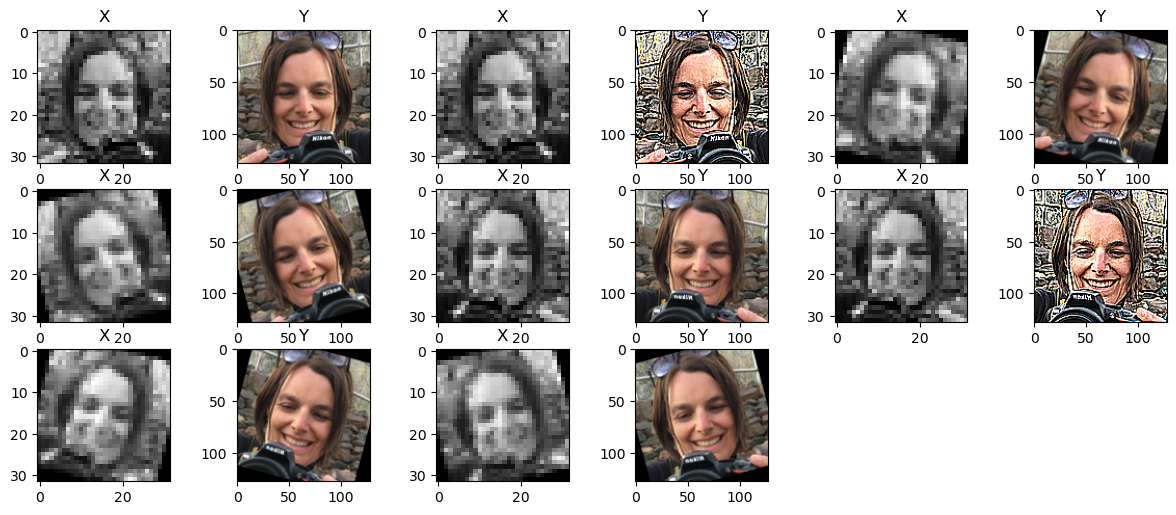

In [16]:
# Test datagen
def do_test_datagen():
    dg = datagen(1)
    img_n = 0

    # do request datagen for two times:
    # every first yields original x and y
    # every second yields augmentated set of x and y
    for _ in range(2):
        x_batch, y_batch = next(dg)

        for ii in range(x_batch.shape[0]):
            img_n += 1
            plt.subplot(5,6,img_n), plt.imshow(x_batch[ii], cmap = 'gray'), plt.title('X')
            img_n += 1
            plt.subplot(5,6,img_n), plt.imshow(y_batch[ii], cmap = 'gray'), plt.title('Y')
           
do_test_datagen()

In [ ]:
# Train the network
epochs = 10
steps_per_epoch = train_set_len / train_batch_size + 1

print(steps_per_epoch)

x_test, y_test = next(data_iterator(test_files_iterator(), test_set_len))

print(len(x_test))

#validation_data = (x_test), np.array(y_test))

model.compile(loss="mse", optimizer="adam", metrics=psnr)

history = model.fit(datagen(train_batch_size), steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test))

1021.0625
1000
Epoch 1/10
   1/1021 [..............................] - ETA: 1:27:11 - loss: 0.2231 - psnr: 6.8925

In [ ]:
test_range = 20

di = data_iterator(test_files_iterator(), test_range)

batch = next(di)
batch = next(di)

x_test = batch[0]

y_test = model.predict(x_test)

#img = np.array(y_test[9])

#plt.imshow(img)

#for ii in range(0, test_range-1):
#    plt.subplot(10, 2, 1), plt.imshow(x_test[ii], cmap='gray')
#    plt.subplot(10, 2, 2), plt.imshow(np.array(y_test[ii]))

for ii in range(test_range):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x_test[ii], cmap='gray')
    #axarr[1].imshow(cv2.resize(x_test[ii], (y_img_size, y_img_size), interpolation=cv2.INTER_LINEAR), cmap='gray')
    axarr[1].imshow(np.array(y_test[ii]))


In [ ]:
model.save('/content/drive/MyDrive/ColabNotebooks/FaceUpscale/model')

In [ ]:
smile = cv2.imread('/content/drive/MyDrive/ColabNotebooks/FaceUpscale/mc.png')
smile = cv2.cvtColor(smile, cv2.COLOR_BGR2GRAY)
smile = smile / 255

l = []
l.append(smile)

smile2 = model.predict(np.array(l))

plt.imshow(np.array(smile2[0]))